# Running SExtractor on simulated galsim images

In [2]:
#install sep

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
# from tqdm import tqdm
import sep
from statistics import mean 
import pandas as pd

In [2]:
BIG_DISTANCE = 1e30
NO_BLEND = 0
BLEND = 1
MISS_EXTRACTION = 16

## Script for SExtractor
Script written by A. Guinot : https://github.com/aguinot

In [3]:
class Run_Sep:
    """
    """

    def __init__(self):
        """
        """

    @staticmethod
    def get_power_2(x):
        """ Get power 2

        Decompose a number on power of 2 and return the powers.

        Example
        -------
        3 -> 1, 2
        16 -> 16
        13 -> 1, 4, 8

        Paramters
        ---------
        x : int
            Number to decompose.

        Returns
        -------
        powers : list
            List of the powers find.

        """

        powers = []
        i = 1
        while i <= x:
            if i & x:
                powers.append(i)
            i <<= 1
        return powers

    def run_sep(self, img, thresh=1.5, deblend_nthresh=32, deblend_cont=0.005, sig_noise=None):
        """ Run sep

        Run sep algorithm on a vignet.

        Parameters
        ----------
        img : numpy.ndarray
            Array containing the image.
        thresh : float
            Detection threshold. (x*sigma_noise with thresh=x)
        deblend_nthresh : int
            Number of bin to do for the blend identification (default = 32).
        deblend_cont : float
            Minimum flux ratio to consider a blend in [0, 1] (default = 0.005).
        sig_noise : float
            Sigma of the noise if known. If None it will be derive from the
            background which might not be accurate on small vignets.

        Returns
        -------
        res : list
            List return by sep.extract.

        """
        sigmas = []

        if sig_noise == None:
            bkg = sep.Background(img)
            sig_noise = bkg.globalrms


        res = sep.extract(img, thresh, err=sig_noise,
                          deblend_nthresh=deblend_nthresh,
                          deblend_cont=deblend_cont)
        return res

    def check_blend(self, res):
        """ Check blend

        Check if objects identify by sep.extract are flagged as blended by
        SExtractor.

        Parameters
        ----------
        res : list
            Output of sep.extract method.

        Returns
        -------
        flags : list
            List of the flag for each objects. flag = 1 if the object is blended
            and 0 otherwise.

        """

        n_obj = len(res)

        flags = [1 if sep.OBJ_MERGED in self.get_power_2(res[i]['flag']) else 0 for i in range(n_obj)] # , dtype=bool).astype(int)

        return flags

    @staticmethod
    def compute_dist(obj_res, obj_true_pos):
        """ Compute distance

        Compute the euclidean distance between 2 points.

        Parameters
        ----------
        obj_res : numpy.ndarray
            Structure array return by sep.extract method for one object.
        obj_true_pos : list
            List containing the true position. (example : [x, y])

        Returns
        -------
        dist : float
            Euclidean distance between 2 points.

        """

        dist = np.sqrt((obj_res['x'] - obj_true_pos[0])**2. + (obj_res['y'] - obj_true_pos[1])**2.)

        return dist

    def get_dist(self, res, true_pos, thresh = 2):
        """ Get distance

        This method return the distance between the real objects and the best
        match find in the SExtractor output. If the distance is larger than the
        the threshold seted then the object is flag.

        Parameters
        ----------
        res : list
            Output of the sep.extract method.
        true_pos : list
            List of the true positions (example : [[x1, y1], [x2, y2], ...]
        thresh : float
            Maximum distance allowed for a match (default = 2)

        Returns
        -------
        numpy.ndarray
            Array containing all the distances.

        """

        dists = []
        ind_used = []
        for i in range(len(true_pos)):
            tmp = BIG_DISTANCE
            for j in range(len(res)):
                tmp2 = self.compute_dist(res[j], true_pos[i])
                ind_tmp = -10
                if (tmp2 < tmp) and (j not in ind_used) and (tmp2 < thresh):
                    tmp = tmp2
                    ind_tmp = j
            ind_used.append(ind_tmp)
            dists.append(tmp)

        return np.array(dists)

    def _check_dist(self, dists):
        """ Check distance

        Flag a list of object depending if SExtractor well identify them or not.
        If at least one object in the list is not well identify will return
        False.

        Parameters
        ----------
        dists : list
            List of distances return by the method get_dist

        Returns
        int
            1 if all the objects are good and 0 otherwise

        """

        return np.prod([1 if dist < BIG_DISTANCE else 0 for dist in dists], dtype=bool).astype(int)

    # def get_blend(self, n_obj_list, flags):
    #     """ Get blend
    #
    #     Check if there is a blend in a vignet. We consider a vignet as blended
    #     if there is more than 1 object or if the object is consider as blended
    #     by SExtractor
    #
    #     Paramters
    #     ---------
    #     n_obj_list : list
    #
    #     """
    #
    #     blend_list = [1 if (n_obj > 1) or (flag == 1) else 0 for n_obj, flag in zip(n_obj_list, flags)]
    #
    #     return blend_list

    def process(self, f, epoch=0):
        """ Process

        Make the all process of blend identification using SExtractor routines.
        Blend definition used :
        0 : no blend
        1 : blend well find
        16 : miss identification

        Parameters
        ----------
        f : numpy.ndarray
            Output of the LenSimu code.
        epoch : int
            Epoch of interest in case of multi-epoch simulations (default = 0).

        Returns
        -------
        blend_flag : numpy.ndarray
            Array containing the final flag for each vignets.

        """

        final_res = []
        final_flags = []
        dists = []
        all_res = []
        blend_flag = []           # 0 : no blend, 1 : blend well find, 16 : miss identification
 
        for obj in f:
            # Retrieve image w/out noise
            #img = obj['galsim_image'][epoch].array
            
            # Retrieve image w/ noise
            img = obj['galsim_image_noisy']

            true_nobj = 1
            if obj['blended'] == True:
                true_nobj += len(obj['blend_param']['dx'])

            res = self.run_sep(img)

            obj_pos = [[img.shape[0] / 2., img.shape[1] / 2.]]

            if len(res) == 0:
                blend_tmp = MISS_EXTRACTION

            elif len(res) == 1:
                if obj['blended'] == True:
                    obj_pos += [[obj_pos[0][0] + obj['blend_param']['dx'][i], obj_pos[0][1] + obj['blend_param']['dy'][i]] for i in range(true_nobj-1)]
                dists_tmp = self.get_dist(res, obj_pos)
                flag = self.check_blend(res)
                if (flag[0]) and self._check_dist(dists_tmp):
                    blend_tmp = BLEND
                else:
                    blend_tmp = NO_BLEND
            elif len(res) == true_nobj:
                obj_pos += [[obj_pos[0][0] + obj['blend_param']['dx'][i], obj_pos[0][1] + obj['blend_param']['dy'][i]] for i in range(true_nobj-1)]
                dists_tmp = self.get_dist(res, obj_pos)
                flag = self.check_blend(res)
                if self._check_dist(dists_tmp):
                    blend_tmp = BLEND
                else:
                    if np.sum([1 if flag[i] and self._check_dist([dists_tmp[i]]) else 0 for i in range(true_nobj)], dtype=bool):
                        blend = BLEND
                    else:
                        blend_tmp = NO_BLEND
            else:
                if obj['blended'] == True:
                    obj_pos += [[obj_pos[0][0] + obj['blend_param']['dx'][i], obj_pos[0][1] + obj['blend_param']['dy'][i]] for i in range(true_nobj-1)]
                dists_tmp = self.get_dist(res, obj_pos)
                flag = self.check_blend(res)
                n_good_dist = np.sum([1 if self._check_dist([dists_tmp[i]]) else 0 for i in range(true_nobj)], dtype=int)
                if n_good_dist == true_nobj:
                    blend_tmp = BLEND
                elif n_good_dist > true_nobj:
                    blend_tmp = MISS_EXTRACTION
                elif np.sum([1 if flag[i] and self._check_dist([dists_tmp[i]]) else 0 for i in range(true_nobj)], dtype=bool):
                    blend_tmp = BLEND
                else:
                    blend_tmp = NO_BLEND

            blend_flag.append(blend_tmp)

            all_res.append(res)
        
        return np.array(blend_flag), all_res
    
    @staticmethod
    def get_estimated_sigma(img):
        bkg = sep.Background(img)
        sig_noise = bkg.globalrms

        return sig_noise
    

    @staticmethod
    def plot_sex_obj(res, img):
        """ Plot SExtractor object

        Plot contours where SExtractor find objects on top of the original
        image.

        Paramters
        ---------
        res : numpy.ndarray
            Structure array return by sep.extract method for one object.
        img : numpy.ndarray
            Array containing the image.

        """

        fig, ax = plt.subplots()
        m, s = np.mean(img), np.std(img)
        im = ax.imshow(img, interpolation='nearest', cmap='gray',
                       vmin=m-s, vmax=m+s, origin='lower')

        # plot an ellipse for each object
        for i in range(len(res)):
            e = Ellipse(xy=(res['x'][i], res['y'][i]),
                        width=6*res['a'][i],
                        height=6*res['b'][i],
                        angle=res['theta'][i] * 180. / np.pi)
            e.set_facecolor('none')
            e.set_edgecolor('red')
            ax.add_artist(e)
        plt.show()

# First test of SExtractor : 90% accuracy

### Import 20 000 simulated images
The dataset is composed by 10 000 blended images and 10 000 not blended images simulated on Galsim with a std deviation of noise at `14.5` 

In [6]:
path = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/axel_sims'

In [ ]:
#Getting the images
blended = np.load(path + '/blended/gal_obj_0.npy', allow_pickle=True)
not_blended = np.load(path + '/not_blended/gal_obj_0.npy', allow_pickle=True)

### Run Sep on  10 000 blended images

In [ ]:
runner = Run_Sep()
flags, sep_res = runner.process(blended)

In [7]:
n_blend = len(np.where(flags == 1)[0])/len(flags)
n_noblend = len(np.where(flags == 0)[0])/len(flags)
n_miss = len(np.where(flags == 16)[0])/len(flags)

print('Blend accuracy : {:.2f}%'.format(n_blend*100))
print('Blend missed : {:.2f}%'.format(n_noblend*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss*100))

Blend accuracy : 89.41%
Blend missed : 10.59%
Wrongly identify (false positives): 0.00%


### Visualizing blend identification

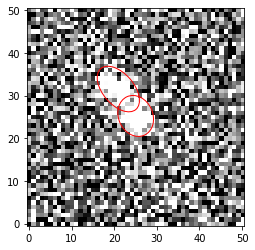

In [71]:
blend_id = np.where(flags == 1)[0][2889]
runner.plot_sex_obj(sep_res[blend_id], blended[blend_id]['galsim_image'][0].array)

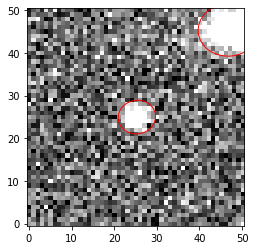

In [87]:
no_blend_id = np.where(flags == 0)[0][1051]
runner.plot_sex_obj(sep_res[no_blend_id], blended[no_blend_id]['galsim_image'][0].array)

# Tests with more simulated data and evolution of Accuracy

# 1. Test SExtractor on 80000 images ($\sigma_{noise} = 0$)

In [6]:
path = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/axel_sims/larger_dataset'

In [7]:
#Getting the images
blended = np.load(path + '/blended/gal_obj_0.npy', allow_pickle=True)
not_blended = np.load(path + '/not_blended/gal_obj_0.npy', allow_pickle=True)

### Run SExtractor

In [ ]:
#Careful to run Sep after retrieving the proper image ('galsim_image') and not 'galsim_image_noisy'.
runner = Run_Sep()
flags, sep_res = runner.process(blended)

In [15]:
n_blend = len(np.where(flags == 1)[0])/len(flags)
n_noblend = len(np.where(flags == 0)[0])/len(flags)
n_miss = len(np.where(flags == 16)[0])/len(flags)

print('Blend accuracy : {:.2f}%'.format(n_blend*100))
print('Blend missed : {:.2f}%'.format(n_noblend*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss*100))

Blend accuracy : 89.24%
Blend missed : 10.76%
Wrongly identify (false positives): 0.00%


#### We obtain an accuracy of `89.24% ` on blended images.

### Visualizing blend identification

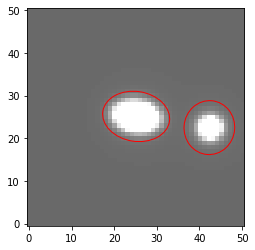

In [77]:
blend_id = np.where(flags == 1)[0][28]
runner.plot_sex_obj(sep_res[blend_id], blended[blend_id]['galsim_image'][0].array)

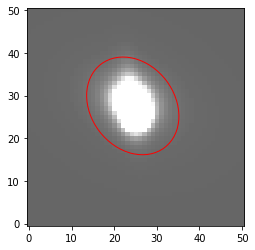

In [78]:
no_blend_id = np.where(flags == 0)[0][4]
runner.plot_sex_obj(sep_res[no_blend_id], blended[no_blend_id]['galsim_image'][0].array)

# 2. Test SExtractor on 80000 images ($\sigma_{noise} = 5$)

In [8]:
path5 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_5'
path5_1 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_5_1'
path5_2 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_5_2'
path5_3 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_5_3'
path5_4 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_5_4'

In [7]:
def sep_results(path=None, sigma_val=None):
    #Get images
    blended_img = np.load(path + '/blended_noisy.npy', allow_pickle=True)
    #Run SExtractor
    runner = Run_Sep()
    flags, sep_res = runner.process(blended_img)
    #Display results
    n_blend = len(np.where(flags == 1)[0])/len(flags)
    n_noblend = len(np.where(flags == 0)[0])/len(flags)
    n_miss = len(np.where(flags == 16)[0])/len(flags)
    print('Blend accuracy : {}%'.format(n_blend*100))
    
    np.save('/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/sep_results/flags_{}.npy'.format(sigma_val), flags)
    
    return n_blend

### Extract images

In [11]:
#Getting the images
blended_5 = np.load(path5 + '/blended_noisy.npy', allow_pickle=True)

### Run SExtractor

In [12]:
runner5 = Run_Sep()
flags5, sep_res5 = runner5.process(blended_5)

In [59]:
n_blend5 = len(np.where(flags5 == 1)[0])/len(flags5)
n_noblend5 = len(np.where(flags5 == 0)[0])/len(flags5)
n_miss5 = len(np.where(flags5 == 16)[0])/len(flags5)

print('Blend accuracy 1st run : {}%'.format(n_blend5*100))
print('Blend missed : {:.2f}%'.format(n_noblend5*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss5*100))

Blend accuracy 1st run : 88.8875%
Blend missed : 11.11%
Wrongly identify (false positives): 0.00%


In [316]:
sigmas = [runner5.get_estimated_sigma(blended_5[img]['galsim_image_noisy']) for img in range(len(blended_5))]
print('Mean of sigma_noise estimated by SExtractor : {}'.format(mean(sigmas)))

Mean of sigma_noise estimated by SExtractor : 5.6031572388291355


#### We obtain an accuracy of `88.89% ` on blended images for a sigma_noise estimated at `5.603` by SExtractor.

### More noise realisations

In [58]:
n_blend5_1 = len(np.where(flags5_1 == 1)[0])/len(flags5_1)
n_blend5_2 = len(np.where(flags5_2 == 1)[0])/len(flags5_2)
n_blend5_3 = len(np.where(flags5_3 == 1)[0])/len(flags5_3)
n_blend5_4 = len(np.where(flags5_4 == 1)[0])/len(flags5_4)

print('Blend accuracy 2nd run : {}%'.format(n_blend5_1*100))
print('Blend accuracy 3rd run : {}%'.format(n_blend5_2*100))
print('Blend accuracy 4th run: {}%'.format(n_blend5_3*100))
print('Blend accuracy 5th run: {}%'.format(n_blend5_4*100))

Blend accuracy 2nd run : 88.815%
Blend accuracy 3rd run : 88.82%
Blend accuracy 4th run: 88.83250000000001%
Blend accuracy 5th run: 88.81750000000001%


In [11]:
### List of paths
paths5 = [path5_1, path5_2, path5_3, path5_4]
sig5 = [5_1, 5_2, 5_3, 5_4]

###RUNNING SEXTRACTOR FOR ALL NOISE REALISATIONS
sep_results_5 = [sep_results(path=i, sigma_val=j) for i,j in zip(paths5, sig5)]

Blend accuracy : 88.815%
Blend accuracy : 88.82%
Blend accuracy : 88.83250000000001%
Blend accuracy : 88.81750000000001%


In [103]:
path5_5 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_5_5'
path5_6 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_5_6'

### List of paths
paths5 = [path5_5, path5_6]

###RUNNING SEXTRACTOR FOR ALL NOISE REALISATIONS
sep_results_5 = [sep_results(i) for i in paths5]

Blend accuracy : 88.80%
Blend accuracy : 88.83%


### Visualizing blend identification

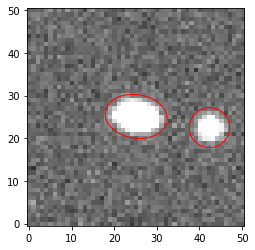

In [262]:
blend_id5 = np.where(flags5 == 1)[0][28]
runner5.plot_sex_obj(sep_res5[blend_id5], blended_5[blend_id5]['galsim_image_noisy'])

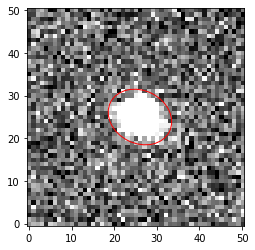

In [263]:
no_blend_id5 = np.where(flags5 == 0)[0][4]
runner5.plot_sex_obj(sep_res5[no_blend_id5], blended_5[no_blend_id5]['galsim_image_noisy'])

# 3. Test SExtractor on 80000 images ($\sigma_{noise} = 14.0$)

In [12]:
path14 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_14'
path14_1 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_14_1'
path14_2 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_14_2'
path14_3 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_14_3'
path14_4 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_14_4'

### Extract images

In [14]:
blended_14 = np.load(path14 + '/blended_noisy.npy', allow_pickle=True)

### Run SExtractor

In [15]:
runner14 = Run_Sep()

In [16]:
flags14, sep_res14 = runner14.process(blended_14)

In [67]:
n_blend14 = len(np.where(flags14 == 1)[0])/len(flags14)
n_noblend14 = len(np.where(flags14 == 0)[0])/len(flags14)
n_miss14 = len(np.where(flags14 == 16)[0])/len(flags14)


print('Blend accuracy 1st run: {:.2f}%'.format(n_blend14*100))
print('Blend missed : {:.2f}%'.format(n_noblend14*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss14*100))

Blend accuracy 1st run: 89.29%
Blend missed : 10.70%
Wrongly identify (false positives): 0.01%


In [323]:
sigmas14 = [runner14.get_estimated_sigma(blended_14[img]['galsim_image_noisy']) for img in range(len(blended_14))]
print('Mean of sigma_noise estimated by SExtractor : {}'.format(mean(sigmas14)))

Mean of sigma_noise estimated by SExtractor : 14.888967147684097


#### We obtain an accuracy of `89.29% ` on blended images for a sigma_noise estimated at `14.889` by SExtractor.

### More noise realisations

In [78]:
n_blend14_1 = len(np.where(flags14_1 == 1)[0])/len(flags14_1)
print('Blend accuracy 2nd run : {:.2f}%'.format(n_blend14_1*100))
n_blend14_2 = len(np.where(flags14_2 == 1)[0])/len(flags14_2)
print('Blend accuracy 3rd run : {:.2f}%'.format(n_blend14_2*100))
n_blend14_3 = len(np.where(flags14_3 == 1)[0])/len(flags14_3)
print('Blend accuracy 4th run : {:.2f}%'.format(n_blend14_3*100))
n_blend14_4 = len(np.where(flags14_4 == 1)[0])/len(flags14_4)
print('Blend accuracy 5th run : {:.2f}%'.format(n_blend14_4*100))

Blend accuracy 2nd run : 89.39%
Blend accuracy 3rd run : 89.37%
Blend accuracy 4th run : 89.42%
Blend accuracy 5th run : 89.35%


In [14]:
### List of paths
paths14 = [path14_1, path14_2, path14_3, path14_4]
sig14 = [14_1, 14_2, 14_3, 14_4]

###RUNNING SEXTRACTOR FOR ALL NOISE REALISATIONS
sep_results_14 = [sep_results(path=i, sigma_val=j) for i,j in zip(paths14, sig14)]

Blend accuracy : 89.39%
Blend accuracy : 89.37%
Blend accuracy : 89.415%
Blend accuracy : 89.35499999999999%


### Visualizing blend identification

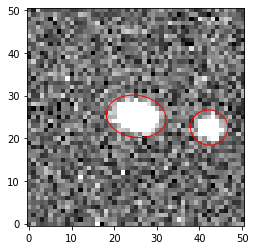

In [180]:
blend_id14 = np.where(flags14 == 1)[0][28]
runner14.plot_sex_obj(sep_res14[blend_id14], blended_14[blend_id14]['galsim_image_noisy'])

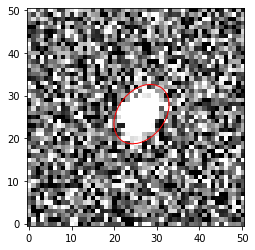

In [182]:
no_blend_id14 = np.where(flags14 == 0)[0][4]
runner14.plot_sex_obj(sep_res14[no_blend_id14], blended_14[no_blend_id14]['galsim_image_noisy'])

# 4. Test SExtractor on 80 000 images ($\sigma_{noise} = 18.0$)

In [15]:
path18 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_18'
path18_1 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_18_1'
path18_2 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_18_2'
path18_3 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_18_3'
path18_4 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_18_4'

In [18]:
blended_18 = np.load(path18 + '/blended_noisy.npy', allow_pickle=True)

### Run SExtractor

In [19]:
runner18 = Run_Sep()
flags18, sep_res18 = runner18.process(blended_18)

In [325]:
n_blend18 = len(np.where(flags18 == 1)[0])/len(flags18)
n_noblend18 = len(np.where(flags18 == 0)[0])/len(flags18)
n_miss18 = len(np.where(flags18 == 16)[0])/len(flags18)


print('Blend accuracy : {:.2f}%'.format(n_blend18*100))
print('Blend missed : {:.2f}%'.format(n_noblend18*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss18*100))

Blend accuracy : 88.31%
Blend missed : 11.65%
Wrongly identify (false positives): 0.03%


In [326]:
sigmas18 = [runner18.get_estimated_sigma(blended_18[img]['galsim_image_noisy']) for img in range(len(blended_18))]
print('Mean of sigma_noise estimated by SExtractor : {}'.format(mean(sigmas18)))

Mean of sigma_noise estimated by SExtractor : 18.97820894675255


#### We obtain an accuracy of `88.31% ` on blended images for a sigma_noise estimated at `18.978` by SExtractor.

In [86]:
n_blend18_1 = len(np.where(flags18_1 == 1)[0])/len(flags18_1)
print('Blend accuracy 2nd run : {}%'.format(n_blend18_1*100))
n_blend18_2 = len(np.where(flags18_2 == 1)[0])/len(flags18_2)
print('Blend accuracy 3rd run : {}%'.format(n_blend18_2*100))

Blend accuracy 2nd run : 88.1875%
Blend accuracy 3rd run : 88.31%


### More noise realisation

In [16]:
###RUNNING SEXTRACTOR FOR ALL NOISE REALISATIONS
### List of paths
paths18 = [path18_1, path18_2, path18_3, path18_4]
sig18 = [18_1, 18_2, 18_3, 18_4]

###RUNNING SEXTRACTOR FOR ALL NOISE REALISATIONS
sep_results_18 = [sep_results(path=i, sigma_val=j) for i,j in zip(paths18, sig18)]

Blend accuracy : 88.1875%
Blend accuracy : 88.31%
Blend accuracy : 88.31%
Blend accuracy : 88.2575%


### Visualizing blend identification

<Figure size 432x288 with 0 Axes>

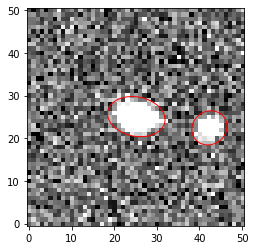

In [249]:
blend_id18 = np.where(flags18 == 1)[0][28]
fig2 = plt.figure()
runner18.plot_sex_obj(sep_res18[blend_id18], blended_18[blend_id18]['galsim_image_noisy'])
fig2.savefig('blend18.png')   # save the figure to file

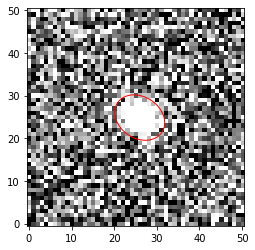

In [186]:
no_blend_id18 = np.where(flags18 == 0)[0][4]
runner18.plot_sex_obj(sep_res18[no_blend_id18], blended_18[no_blend_id18]['galsim_image_noisy'])

# 5. Test SExtractor on 80000 images ($\sigma_{noise} = 26.0$)

In [17]:
path26 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_26'
path26_1 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_26_1'
path26_2 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_26_2'
path26_3 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_26_3'
path26_4 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_26_4'

In [21]:
blended_26 = np.load(path26 + '/blended_noisy.npy', allow_pickle=True)
blended_26.shape

(40000,)

### Run SExtractor

In [22]:
runner26 = Run_Sep()
flags26, sep_res26 = runner26.process(blended_26)

In [328]:
n_blend26 = len(np.where(flags26 == 1)[0])/len(flags26)
n_noblend26 = len(np.where(flags26 == 0)[0])/len(flags26)
n_miss26 = len(np.where(flags26 == 16)[0])/len(flags26)


print('Blend accuracy : {:.2f}%'.format(n_blend26*100))
print('Blend missed : {:.2f}%'.format(n_noblend26*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss26*100))

Blend accuracy : 79.88%
Blend missed : 19.86%
Wrongly identify (false positives): 0.26%


In [329]:
sigmas26 = [runner26.get_estimated_sigma(blended_26[img]['galsim_image_noisy']) for img in range(len(blended_26))]
print('Mean of sigma_noise estimated by SExtractor : {}'.format(mean(sigmas26)))

Mean of sigma_noise estimated by SExtractor : 27.10144787106514


#### We obtain an accuracy of `79.88% ` on blended images for a sigma_noise estimated at `27.101` by SExtractor.

### Visualizing blend identification

<Figure size 432x288 with 0 Axes>

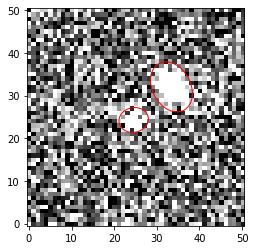

In [265]:
blend_id26 = np.where(flags26 == 1)[0][28]
fig3 = plt.figure()
runner26.plot_sex_obj(sep_res26[blend_id26], blended_26[blend_id26]['galsim_image_noisy'])
fig3.savefig('blend26.png')   # save the figure to file

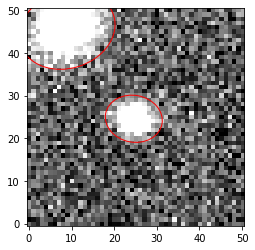

In [272]:
no_blend_id26 = np.where(flags26 == 0)[0][4]
runner26.plot_sex_obj(sep_res26[no_blend_id26], blended_26[no_blend_id26]['galsim_image_noisy'])

### More noise realisations

In [18]:
### List of paths
paths26 = [path26_1, path26_2, path26_3, path26_4]
sig26 = [26_1, 26_2, 26_3, 26_4]
###RUNNING SEXTRACTOR FOR ALL NOISE REALISATIONS
sep_results_26 = [sep_results(path=i, sigma_val=j) for i,j in zip(paths26, sig26)]

Blend accuracy : 79.71000000000001%
Blend accuracy : 79.91%
Blend accuracy : 79.965%
Blend accuracy : 79.7%


# 6. Test SExtractor on 80000 images ($\sigma_{noise} = 35.0$)

In [23]:
path35 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_35'

blended_35 = np.load(path35 + '/blended_noisy.npy', allow_pickle=True)
blended_35.shape

(40000,)

In [24]:
### Run Sextractor

runner35 = Run_Sep()
flags35, sep_res35 = runner35.process(blended_35)

n_blend35 = len(np.where(flags35 == 1)[0])/len(flags35)
n_noblend35 = len(np.where(flags35 == 0)[0])/len(flags35)
n_miss35 = len(np.where(flags35 == 16)[0])/len(flags35)

In [338]:
print('Blend accuracy : {:.2f}%'.format(n_blend35*100))
print('Blend missed : {:.2f}%'.format(n_noblend35*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss35*100))

Blend accuracy : 63.28%
Blend missed : 34.87%
Wrongly identify (false positives): 1.85%


In [339]:
sigmas35 = [runner35.get_estimated_sigma(blended_35[img]['galsim_image_noisy']) for img in range(len(blended_35))]
print('Mean of sigma_noise estimated by SExtractor : {}'.format(mean(sigmas35)))

Mean of sigma_noise estimated by SExtractor : 36.17021199131012


#### We obtain an accuracy of `63.09% ` on blended images for a sigma_noise estimated at `36.170` by SExtractor.

### Visualizing blend identification

<Figure size 432x288 with 0 Axes>

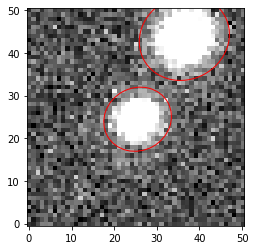

In [279]:
blend_id35 = np.where(flags35 == 1)[0][28]
fig4 = plt.figure()
runner35.plot_sex_obj(sep_res35[blend_id35], blended_35[blend_id35]['galsim_image_noisy'])
fig3.savefig('blend35.png')   # save the figure to file

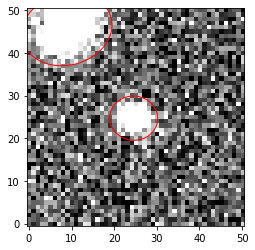

In [280]:
no_blend_id35 = np.where(flags35 == 0)[0][4]
runner35.plot_sex_obj(sep_res35[no_blend_id35], blended_35[no_blend_id35]['galsim_image_noisy'])

### More noise realisations

In [19]:
path35 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_35'
path35_1 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_35_1'
path35_2 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_35_2'
path35_3 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_35_3'
path35_4 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_35_4'

In [20]:
### List of paths
paths35 = [path35_1, path35_2, path35_3, path35_4]
sig35 = [35_1, 35_2, 35_3, 35_4]
###RUNNING SEXTRACTOR FOR ALL NOISE REALISATIONS
sep_results_35 = [sep_results(path=i, sigma_val=j) for i,j in zip(paths35, sig35)]

Blend accuracy : 62.885000000000005%
Blend accuracy : 63.154999999999994%
Blend accuracy : 62.9125%
Blend accuracy : 62.957499999999996%


# 7. Test SExtractor on 80 000 images ($\sigma_{noise} = 40.0$)

In [25]:
path40 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_40'

blended_40 = np.load(path40 + '/blended_noisy.npy', allow_pickle=True)
blended_40.shape

(40000,)

### Run SExtractor

In [26]:
runner40 = Run_Sep()
flags40, sep_res40 = runner40.process(blended_40)

In [113]:
flags40.shape

(40000,)

In [112]:
n_blend40 = len(np.where(flags40 == 1)[0])/len(flags40)
n_noblend40 = len(np.where(flags40 == 0)[0])/len(flags40)
n_miss40 = len(np.where(flags40 == 16)[0])/len(flags40)

print('Blend accuracy : {:.2f}%'.format(n_blend40*100))
print('Blend missed : {:.2f}%'.format(n_noblend40*100))
print('Wrongly identify : {:.2f}%'.format(n_miss40*100))

sigmas40 = [runner40.get_estimated_sigma(blended_40[img]['galsim_image_noisy']) for img in range(len(blended_40))]
print('Mean of sigma_noise estimated by SExtractor : {}'.format(mean(sigmas40)))

Blend accuracy : 53.25%
Blend missed : 42.78%
Wrongly identify : 3.97%
Mean of sigma_noise estimated by SExtractor : 41.17211955661774


#### We obtain an accuracy of `53.25% ` on blended images for a sigma_noise estimated at ` 41.172` by SExtractor.

### Visualizing blend identification

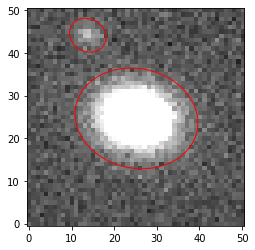

In [340]:
blend_id40 = np.where(flags40 == 1)[0][28]
runner40.plot_sex_obj(sep_res40[blend_id40], blended_40[blend_id40]['galsim_image_noisy'])

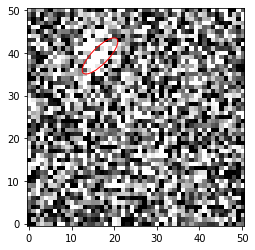

In [341]:
no_blend_id40 = np.where(flags40 == 0)[0][4]
runner40.plot_sex_obj(sep_res40[no_blend_id40], blended_40[no_blend_id40]['galsim_image_noisy'])

### More noise realisations

In [21]:
path40_1 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_40_1'
path40_2 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_40_2'
path40_3 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_40_3'
path40_4 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_40_4'


### List of paths
paths40 = [path40_1, path40_2, path40_3, path40_4]
sig40= [40_1, 40_2, 40_3, 40_4]
###RUNNING SEXTRACTOR FOR ALL NOISE REALISATIONS
sep_results_40 = [sep_results(path=i, sigma_val=j) for i,j in zip(paths40, sig40)]

Blend accuracy : 53.4625%
Blend accuracy : 53.225%
Blend accuracy : 53.42750000000001%
Blend accuracy : 53.3225%


In [129]:
flags5

array([1, 1, 1, ..., 0, 1, 1])

In [130]:
flags14

array([1, 1, 1, ..., 0, 1, 1])

In [131]:
flags18

array([1, 1, 1, ..., 0, 1, 1])

In [132]:
flags26

array([0, 1, 1, ..., 0, 1, 0])

In [133]:
flags35

array([0, 0, 1, ..., 0, 1, 0])

In [151]:
flags40.transpose()

array([ 0,  0,  1, ...,  0,  1, 16])

In [29]:
f40=flags40.reshape(40000,1)

In [30]:
f40 = f40.transpose()
f40.shape

(1, 40000)

In [34]:
np.save('/Users/alacan/Documents/Cosmostat/Codes/Blendhunter/SExt_results/flags5.npy', flags5)
np.save('/Users/alacan/Documents/Cosmostat/Codes/Blendhunter/SExt_results/flags14.npy', flags14)
np.save('/Users/alacan/Documents/Cosmostat/Codes/Blendhunter/SExt_results/flags18.npy', flags18)
np.save('/Users/alacan/Documents/Cosmostat/Codes/Blendhunter/SExt_results/flags26.npy', flags26)
np.save('/Users/alacan/Documents/Cosmostat/Codes/Blendhunter/SExt_results/flags35.npy', flags35)
np.save('/Users/alacan/Documents/Cosmostat/Codes/Blendhunter/SExt_results/flags40.npy', flags40)